In [35]:
%matplotlib inline
from os.path import join as opj
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import (OneSampleTTestDesign, EstimateModel,
                                   EstimateContrast, Threshold)
from nipype.interfaces.utility import Function, IdentityInterface
from nipype import Workflow, Node
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip

In [36]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12')

In [37]:
import pickle
with open("/home/zohyos7/republicans_tom.txt", "rb") as fp:
    republicans = pickle.load(fp)
with open("/home/zohyos7/democrats_tom.txt", "rb") as fp:
    democrats = pickle.load(fp)
with open("/home/zohyos7/independents_tom.txt", "rb") as fp:
    independents = pickle.load(fp)

In [38]:
subject_list = republicans + democrats + independents

In [39]:
subject_list.remove(2357)

In [40]:
len(subject_list)

151

In [41]:
experiment_dir = '/data/wellbeing_analysis'
output_dir = 'datasink'
working_dir = 'workingdir'

# Smoothing withds used during preprocessing
fwhm = [4, 8]

# Which contrasts to use for the 2nd-level analysis
contrast_list = ['con_0001', 'con_0002', 'con_0003', 'con_0004', 'ess_0005']

# Which task to analyze 
task_list = ['tom']

mask = "/home/zohyos7/fmri/mni_icbm152_nlin_asym_09c/1mm_brainmask.nii.gz"

In [42]:
# Gunzip - unzip the mask image
gunzip = Node(Gunzip(in_file=mask), name="gunzip")

# OneSampleTTestDesign - creates one sample T-Test Design
onesamplettestdes = Node(OneSampleTTestDesign(),
                         name="onesampttestdes")

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont1]

# Threshold - thresholds contrasts
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.005,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),
                    name="level2thresh")

In [43]:
def getcontrasts(contrast_id, fwhm_id, task_name, subject_list):
    from os.path import join as opj
    cons = [opj('/data/wellbeing_analysis/datasink/antsflow', 'sub-%s', 'con', 'task-%s', 'fwhm-%s',
                         '%s_trans.nii')% (sub, task_name, fwhm_id, contrast_id)
                                         for sub in subject_list]
    return cons

In [44]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['contrast_id', 'fwhm_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('contrast_id', contrast_list),
                        ('fwhm_id', fwhm),
                        ('task_name', task_list)]
infosource.inputs.subject_list = subject_list 

# SelectFiles - to grab the data (alternativ to DataGrabber)
getcontrasts = Node(Function(input_names=['contrast_id', 'fwhm_id', 'task_name', 'subject_list'],
                               output_names=['cons'],
                               function=getcontrasts),
                      name='getcontrasts')

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_contrast_id_', '')]
subjFolders = [('%s_fwhm_id_%s_task_name_%s' % (con, f, task), 'task_%s/fwhm_%s/%s' % (task, f, con))
               for f in fwhm
               for con in contrast_list
               for task in task_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [45]:
# Initiation of the 2nd-level analysis workflow
BL_one_sample = Workflow(name='BL_one_sample')
BL_one_sample.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
BL_one_sample.connect([(infosource, getcontrasts, [('contrast_id', 'contrast_id'),
                                               ('fwhm_id', 'fwhm_id'),
                                               ('task_name', 'task_name'),
                                                  ('subject_list', 'subject_list')]),
                    (getcontrasts, onesamplettestdes, [('cons', 'in_files')]),
                    (gunzip, onesamplettestdes, [('out_file',
                                                  'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2estimate, datasink, [('mask_image',
                                                 'BL_one_sample.@mask')]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    'BL_one_sample.@spm_mat'),
                                                   ('spmT_images',
                                                    'BL_one_sample.@T'),
                                                   ('con_images',
                                                    'BL_one_sample.@con')]),
                    ])

181115-12:41:24,350 nipype.workflow INFO:
	 Generated workflow graph: /data/wellbeing_analysis/workingdir/BL_one_sample/graph.png (graph2use=colored, simple_form=True).


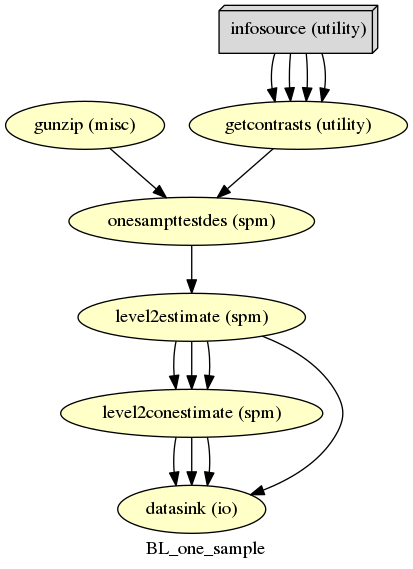

In [46]:
# Create 1st-level analysis output graph
BL_one_sample.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(BL_one_sample.base_dir, 'BL_one_sample', 'graph.png'))

In [47]:
BL_one_sample.run('MultiProc', plugin_args={'n_procs': 8})

181115-12:41:25,12 nipype.workflow INFO:
	 Workflow BL_one_sample settings: ['check', 'execution', 'logging', 'monitoring']
181115-12:41:25,108 nipype.workflow INFO:
	 Running in parallel.
181115-12:41:25,113 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 11 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 8/8.
181115-12:41:25,213 nipype.workflow INFO:
	 [Node] Setting-up "BL_one_sample.getcontrasts" in "/data/wellbeing_analysis/workingdir/BL_one_sample/_contrast_id_ess_0005_fwhm_id_8_task_name_tom/getcontrasts".181115-12:41:25,214 nipype.workflow INFO:
	 [Node] Setting-up "BL_one_sample.getcontrasts" in "/data/wellbeing_analysis/workingdir/BL_one_sample/_contrast_id_ess_0005_fwhm_id_4_task_name_tom/getcontrasts".181115-12:41:25,213 nipype.workflow INFO:
	 [Node] Outdated cache found for "BL_one_sample.getcontrasts".

181115-12:41:25,228 nipype.workflow INFO:
	 [Node] Outdated cache found for "BL_one_sample.getcontrasts".

181115-12:41:25,237 nipype.workflow INFO